In [1]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from typing import List, Tuple, Dict
import matplotlib.gridspec as gridspec

eTypes: Dict[int, str]     = {0: 'email',1: 'phone',2: 'sells',3: 'buys',4: 'author',5: 'financial',6: 'travels_to'}
eTypes_inv: Dict[str, int] = {v: k for k, v in eTypes.items()}
demographic_categories     = dict([(row['NodeID'], row['Category']) for (_, row) in pd.read_csv('data/DemographicCategories.csv').iterrows()])
categories                 = demographic_categories.values()

template_nodetypes  = pd.read_csv("data/CGCS-Template-NodeTypes.csv")
candidate_nodetypes = pd.read_csv("data/CGCS-GraphData-NodeTypes.csv")

template_people  = template_nodetypes.loc[template_nodetypes.NodeType.isin([1])]['NodeID'].to_list()
candidate_people = candidate_nodetypes.loc[candidate_nodetypes.NodeType.isin([1])]['NodeID'].to_list()
 
# cargar template y candidatos

template   = pd.read_csv("data/template.csv")
candidate1 = pd.read_csv("data/candidato1.csv")
candidate2 = pd.read_csv("data/candidato2.csv")
candidate3 = pd.read_csv("data/candidato3.csv")
candidate4 = pd.read_csv("data/candidato4.csv")
candidate5 = pd.read_csv("data/candidato5.csv")

In [5]:
financial_channel     = template.loc[template.eType.isin([eTypes_inv['financial']])]
travel_channel        = template.loc[template.eType.isin([eTypes_inv['travels_to']])]
communication_channel = template.loc[template.eType.isin([eTypes_inv['email'], eTypes_inv['phone']])]

people_with_financial_data = set([person for person in financial_channel.Source if person in template_people])

travellers               = set(travel_channel.Source.unique())
communicators            = set(communication_channel.Source.unique()).union(set(communication_channel.Target.unique()))
travellers_communicators = travellers.intersection(communicators)
others                   = set([person for person in template_people if person not in communicators and person not in travellers])

travellers_demographics    = financial_channel.loc[financial_channel.Source.isin(travellers)][['Source','Target','Weight','demo_category']]
communicators_demographics = financial_channel.loc[financial_channel.Source.isin(communicators)][['Source','Target','Weight','demo_category']]
others_demographics        = financial_channel.loc[financial_channel.Source.isin(others)][['Source','Target','Weight','demo_category']]

travellers_expenses    = travellers_demographics.groupby(['demo_category']).agg({'Weight' : 'sum'}).to_dict()['Weight']
communicators_expenses = communicators_demographics.groupby(['demo_category']).agg({'Weight' : 'sum'}).to_dict()['Weight']
others_expenses        = others_demographics.groupby(['demo_category']).agg({'Weight' : 'sum'}).to_dict()['Weight']

# len(template_people), len(travellers), len(communicators), len(travellers_communicators), len(others)

# dibujar

plt.style.use('default') # ('dark_background')
gs = gridspec.GridSpec(4, 1)
fig = plt.figure(figsize=(20,15))
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2, :])
ax4 = fig.add_subplot(gs[3, :])
ax1.title.set_text('gastos: gente que viaja (escala propia)')
ax2.title.set_text('gastos: gente que viaja')
ax3.title.set_text('gastos: gente comunicada')
ax4.title.set_text('gastos: otra gente (ni viajeros ni comunicados)')
ax1.title.set_fontsize(15)
for ax in [ax2,ax3,ax4]:
    ax.title.set_fontsize(15)
    ax.set_ylim(top=155000)
    plt.sca(ax)
for ax in [ax1,ax2,ax3]:
    ax.xaxis.set_major_locator(plt.NullLocator())
plt.xticks(rotation=90, fontsize=15)

ax1.annotate(travellers_demographics.Source.unique(), xy=(1, 8000))
ax2.annotate(travellers_demographics.Source.unique(), xy=(1, 140000))
ax3.annotate(communicators_demographics.Source.unique(), xy=(1, 140000))
ax4.annotate(others_demographics.Source.unique(), xy=(1, 140000))

for (subfigure, df) in [(ax1, travellers_expenses),
                        (ax2, travellers_expenses),
                        (ax3, communicators_expenses),
                        (ax4, others_expenses)]:
    subfigure.bar(categories,[df.get(category,0) for category in categories])

#plt.savefig("gastos.png")

(51, 16, 17, 3, 21)

In [133]:
def plot_demographics(df: pd.DataFrame, df_name: str, people: List[int]) -> None:
    
    financial_channel     = df.loc[df.eType.isin([eTypes_inv['financial']])]
    travel_channel        = df.loc[df.eType.isin([eTypes_inv['travels_to']])]
    communication_channel = df.loc[df.eType.isin([eTypes_inv['email'], eTypes_inv['phone']])]
    
    people_with_financial_data = set([person for person in financial_channel.Source if person in people])
    
    travellers               = set(travel_channel.Source.unique())
    communicators            = set(communication_channel.Source.unique()).union(set(communication_channel.Target.unique()))
    travellers_communicators = travellers.intersection(communicators)
    others                   = set([person for person in people_with_financial_data 
                                    if person not in communicators and person not in travellers and person in people])
    
    travellers_demographics    = financial_channel.loc[financial_channel.Source.isin(travellers)][['Source','Target','Weight','demo_category']]
    communicators_demographics = financial_channel.loc[financial_channel.Source.isin(communicators)][['Source','Target','Weight','demo_category']]
    others_demographics        = financial_channel.loc[financial_channel.Source.isin(others)][['Source','Target','Weight','demo_category']]
    
    travellers_expenses    = travellers_demographics.groupby(['demo_category']).agg({'Weight' : 'sum'}).to_dict()['Weight']
    communicators_expenses = communicators_demographics.groupby(['demo_category']).agg({'Weight' : 'sum'}).to_dict()['Weight']
    others_expenses        = others_demographics.groupby(['demo_category']).agg({'Weight' : 'sum'}).to_dict()['Weight']

    plt.style.use('default') # ('dark_background')   
    gs = gridspec.GridSpec(4, 1)
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])
    ax4 = fig.add_subplot(gs[3, :])
    ax1.title.set_text('gastos: gente que viaja (escala propia)')
    ax2.title.set_text('gastos: gente que viaja')
    ax3.title.set_text('gastos: gente comunicada')
    ax4.title.set_text('gastos: otra gente (ni viajeros ni comunicados)')
    ax1.title.set_fontsize(15)
    for ax in [ax2,ax3,ax4]:
        ax.title.set_fontsize(15)
        ax.set_ylim(top=160000)
        plt.sca(ax)
    for ax in [ax1,ax2,ax3]:
        ax.xaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(rotation=90, fontsize=15)
    top_y = {'template': 8000, 'Q1': 40000, 'Q2':3000, 'Q3':9000, 'Q4':40000, 'Q5':40000}    
    ax1.annotate(travellers_demographics.Source.unique(), xy=(0, top_y.get(df_name)))
    ax2.annotate(travellers_demographics.Source.unique(), xy=(0, 130000))
    ax3.annotate(communicators_demographics.Source.unique(), xy=(0, 130000))
    ax4.annotate(others_demographics.Source.unique(), xy=(0, 130000))
        
    for (subfigure, df) in [(ax1, travellers_expenses),
                            (ax2, travellers_expenses),
                            (ax3, communicators_expenses),
                            (ax4, others_expenses)]:
        subfigure.bar(categories,[df.get(category,0) for category in categories])
        
    plt.savefig("gastos_comparados/" + df_name + "_gastos.png")

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


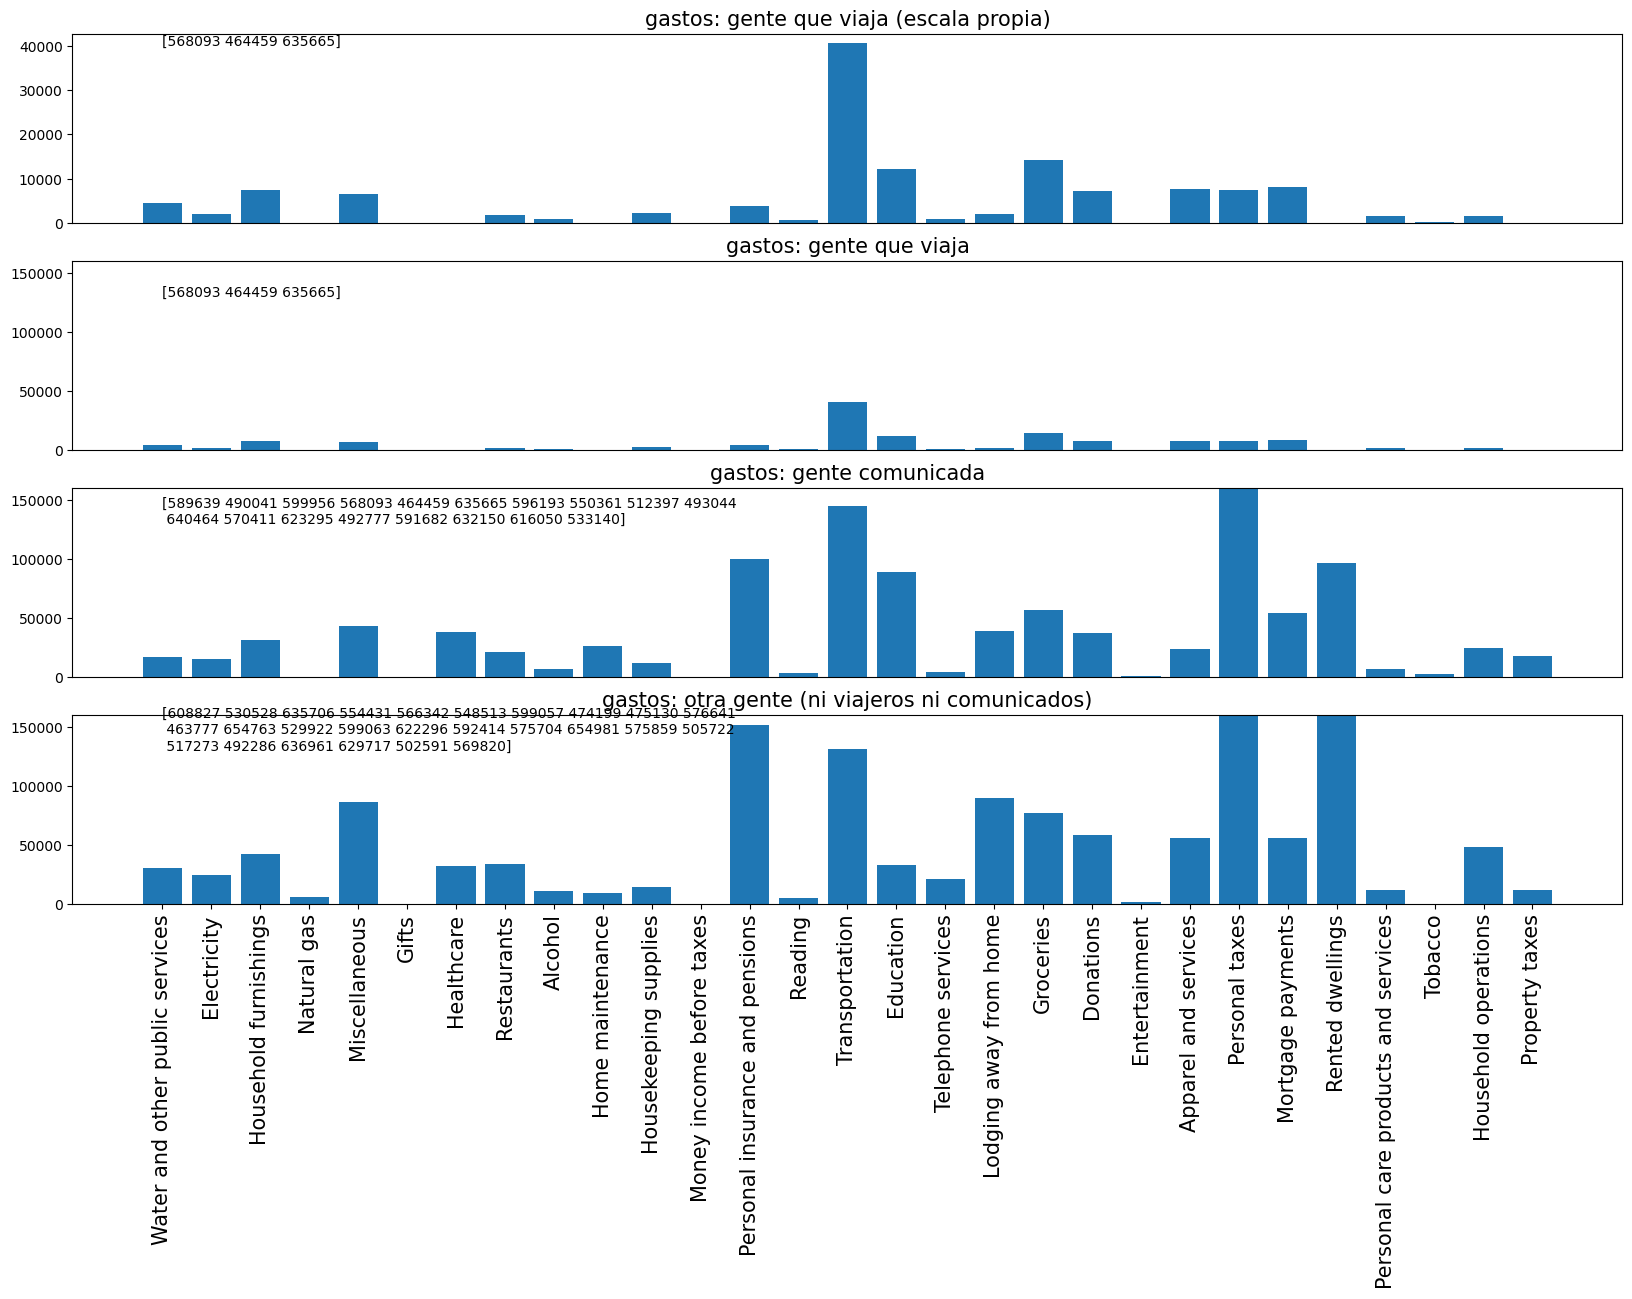

In [134]:
plot_demographics(template, 'template', template_people)
plot_demographics(candidate1, 'Q1', candidate_people)
plot_demographics(candidate2, 'Q2', candidate_people)
plot_demographics(candidate3, 'Q3', candidate_people)
plot_demographics(candidate4, 'Q4', candidate_people)
plot_demographics(candidate5, 'Q5', candidate_people)